# recordclass: компактные и быстрые объекты

In [1]:
from recordclass import dataobject
from recordclass import litelist, litetuple, litelist_fromargs
import matplotlib.pyplot as plt
import sys
print(sys.version)

3.9.7 (default, Sep 24 2021, 09:43:00) 
[GCC 10.3.0]


В CPython начиная с версии 2.2 модуль `gc` был интегрирован в ядро. До этого единственным механизмом для сборки мусора был механизм подсчета ссылок.

Он работает следующим образом: как только счетчик числа ссылок становится равным нулю происходит удаление объекта из памяти:

    if (ob->ob_refcnt == 0)
        Py_TYPE(ob)->tp_dealloc(ob);

После интеграции `gc` с ядром CPython все пользовательские классы, порожденные при помощи оператора `class`, стали автоматически включаться в механизм поиска циклов. Но, по-прежнему, как только счетчик числа ссылок в экземпляре становится равным нулю, объект сразу удаляется из памяти.

Интеграция `gc` привела к тому, что к каждому экземпляру стал прибавляться в оперативной памяти префикс `PyGC_Head`, который в настоящее время имеет размер 16 байт (для 64-битных систем), до CPython 3.8 он занимал в памяти 24 байта. Кроме этого переодические запускается механизм обнаружения циклов. Подавляющее большинство программ ничего *"не почувствуют"*.  Однако, если в памяти находится очень большое число объектов, то для некоторых высоко нагруженных систем с ограничениями на объем используемой памяти это может создавать трудности. С многими из них можно успешно бороться, используя современный функционал модуля `gc`.

Все же для большого класса объектов этот механизм скорее избыточен. Рассмотрим в качестве примера простой конкретный класс для представления точки на плоскости:

In [2]:
class Point:
    x: int
    y: int
    def __init__(self, x, y):
        self.x = x
        self.y = y

Адекватное использование экземпляров этого классе в программах и скриптах на CPython не может привести к образованию ссылочных циклов. Если какой-нибудь экземпляр этого класса участвует в ссылочным цикле, в котором он опосредованно ссылается на самого себя, то это означает **ошибку** в программе, так как его атрибуты должны иметь **только** простой тип. Впрочем, ничто в Python не мешает *"выстрелить себе в ногу"*.

В то же время размер экземпляра оставляет желать лучшего:

Использование модуля `dataclass` из стандартной библиотеки существенно облегчает создание таких классов:

In [3]:
from dataclasses import dataclass

@dataclass
class Point:
    x: int
    y: int

In [4]:
p = Point(1.,2.)
print(p)
print(sys.getsizeof(p) + sys.getsizeof(p.__dict__))

Point(x=1.0, y=2.0)
152


Для уменьшения размера экземпляра существует "прием" со `__slots__` (уже работает с `dataclass` в CPython 3.10):

In [5]:
class PointSlots:
    __slots__ = 'x', 'y'
    x: int
    y: int
    def __init__(self, x, y):
        self.x = x
        self.y = y

In [6]:
p = PointSlots(1.,2.)
print(sys.getsizeof(p))

48


В экземплярах таких классов отсутствует словарь `__dict__`, нет `__weakref__`, значения атрибутов (ссылки на объекты) хранятся статически в самом экземпляре:

|  поле  | размер |
|:---------------|--:|
| `PyGC_Head` | 16 |
| `PyObject_HEAD` | 16 |
| `PyObject* x` | 8 |
| `PyObject* y` | 8 |

**P.S.** *В CPython < 3.8 размер `PyGC_Head` равен 24 байтам.*


Использование таких классов позволяет существенно уменьшить след экземпляров в оперативной памяти. Но классы со `__slots__` по-прежнему участвуют в механизме поиска ссылочных циклов и имеют префикс `PyGC_Head`. Начиная с CPython 3.10 `dataclass` имеет аргумент `slots`, которые позволяет создавать классы со `__slots__`.

В библиотеке [recordclass](https://pypi.org/project/recordclass/) реализован механизм создания классов, которые поддерживают **только** механизм подсчета ссылок для утилизации экземпляра и, соответственно, не имеют префикса `PyGC_Head`. Достигается это путем наследования от специального базового класса `dataobject`:

In [7]:
class PointDO(dataobject):
    x: int
    y: int

In [8]:
p = PointDO(1.,2.)
print(p)
print(sys.getsizeof(p))

PointDO(x=1.0, y=2.0)
32


Экземпляры классов, основанные на `dataobject`, имеют такую же структуру в оперативной памяти, за исключением отсутствия `PyGC_Head`:

|  поле  | размер |
|:---------------|--:|
| `PyObject_HEAD` | 16 |
| `PyObject* x` | 8 |
| `PyObject* y` | 8 |

Другое отличие состоит в том, что дескрипторы для доступа к полям экземпляра, в отличие от классов со `__slots__`, находятся в словаре класса.

Есть возможность ускорить создание экземпляра взамен на ослабление возможностей по интроспекции аргументов у `__new__`:

In [9]:
class PointDO(dataobject, fast_new=True):
    x: int
    y: int

%timeit l=[Point(i, i) for i in range(1_000_000)] 
%timeit l=[PointSlots(i, i) for i in range(1_000_000)] 
%timeit l=[PointDO(i, i) for i in range(1_000_000)] 

263 ms ± 2.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
209 ms ± 439 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
109 ms ± 5.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


В библиотеке `recordclass` также есть аналоги списка и кортежа, которые также не участвуют в механизме обнаружения ссылочных циклов и не имеют префикса `PyGC_Head`. С их помощью можно создавать классы для представления терминальных структур данных, экземпляры которых являются более компактными по размеру в оперативной памяти. Например:

In [10]:
class PolygonDO(dataobject, fast_new=True):
    nodes: litelist

Для сравнения приведем аналогичный класс со `__slots__`:

In [11]:
class PolygonSlots:
    __slots__ = 'nodes'
    def __init__(self, nodes):
        self.nodes = nodes

Созданим одинаковые по содержанию экземпляры классов и сравним их размеры:

In [12]:
p = PolygonSlots([PointSlots(0,1), PointSlots(1,2), PointSlots(2,0)])
print('Размер структуры:', 
      sys.getsizeof(p), sys.getsizeof(p.nodes), 3*sys.getsizeof(p.nodes[0]),
      "всего:", sys.getsizeof(p)+sys.getsizeof(p.nodes)+3*sys.getsizeof(p.nodes[0]))

Размер структуры: 40 80 144 всего: 264


In [13]:
p = PolygonDO(litelist_fromargs(PointDO(0,1), PointDO(1,2), PointDO(2,0)))
print('Размер структуры:', 
      sys.getsizeof(p), sys.getsizeof(p.nodes), 3*sys.getsizeof(p.nodes[0]),
      "всего:", sys.getsizeof(p)+sys.getsizeof(p.nodes)+3*sys.getsizeof(p.nodes[0]))

Размер структуры: 24 64 96 всего: 184


На создание экземпляров `PolygonDO` уходит почти в два раза меньше времени, чем на создание `PolygonSlots`:

In [14]:
def test_do():
    for i in range(1_000_000):
        p = PolygonDO(litelist_fromargs(PointDO(i,i+1), PointDO(i+1,i+2), PointDO(i+2,i)))
        p_prev = p

def test_slots():
    for i in range(1_000_000):
        p = PolygonSlots([PointSlots(i,i+1), PointSlots(i+1,i+2), PointSlots(i+2,i)])
        p_prev = p

%timeit l=test_slots()
%timeit l=test_do()

755 ms ± 2.79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
385 ms ± 5.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
class Point(dataobject, fast_new=True):
    x:int
    y:int
    z:int

class PointGC(dataobject, gc=True, fast_new=True):
    x:int
    y:int
    z:int

class PointSlots:
    __slots__ = 'x', 'y','z'
    
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z


In [56]:
import gc
import time

def test_with_slots(N=10_000_000):
    # gc.collect(2)
    t0 = time.perf_counter()
    for i in range(N):
        p = PointSlots(i, i, i)
#     gc.collect()
    return time.perf_counter() - t0

def test_with_gc(N=10_000_000):
    # gc.collect(2)
    t0 = time.perf_counter()
    for i in range(N):
        p = PointGC(i, i, i)
#     gc.collect()
    return time.perf_counter() - t0
        
def test_without_gc(N=10_000_000):
    # gc.collect(2)
    t0 = time.perf_counter()
    for i in range(N):
        p = Point(i, i, i)
#     gc.collect()
    return time.perf_counter() - t0

        

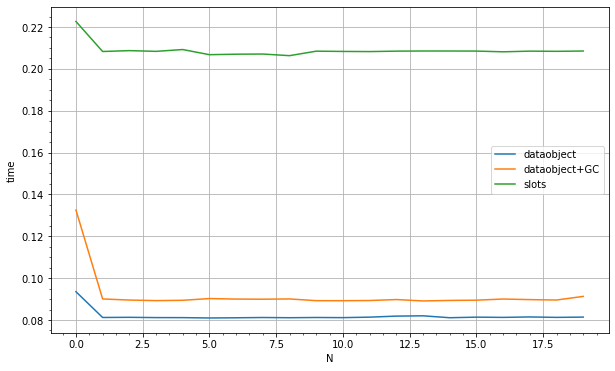

In [59]:
import numpy as np
import gc
Ns = 20*[2**20]
gc.collect()
gc.collect(2)
timings2 = np.array([test_with_gc(N) for N in Ns], 'd')
gc.collect()
gc.collect(2)
timings3 = np.array([test_with_slots(N) for N in Ns], 'd')
gc.collect()
gc.collect(2)
timings1 = np.array([test_without_gc(N) for N in Ns], 'd')
plt.figure(figsize=(10,6))
plt.plot(timings1, label="dataobject")
plt.plot(timings2, label="dataobject+GC")
plt.plot(timings3, label="slots")
plt.legend()
plt.xlabel('N')
plt.ylabel('time')
plt.minorticks_on()
plt.grid(1)
plt.savefig("objects_without_cyclic_GC1.jpg")
plt.show()

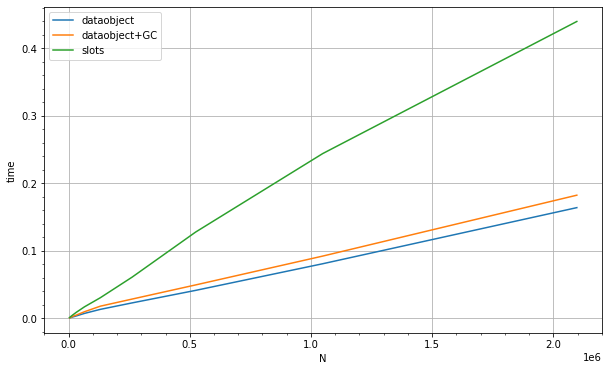

In [54]:
import numpy as np
import gc
Ns = [2**n for n in range(12,22)]
Ms = list(range(12,22))
gc.collect(2)
timings2 = np.array([test_with_gc(N) for N in Ns], 'd')
gc.collect(2)
timings3 = np.array([test_with_slots(N) for N in Ns], 'd')
gc.collect(2)
timings1 = np.array([test_without_gc(N) for N in Ns], 'd')
plt.figure(figsize=(10,6))
plt.plot(Ns, timings1, label="dataobject")
plt.plot(Ns, timings2, label="dataobject+GC")
plt.plot(Ns, timings3, label="slots")
plt.legend()
plt.xlabel('N')
plt.ylabel('time')
plt.minorticks_on()
plt.grid(1)
plt.savefig("objects_without_cyclic_GC1.jpg")
plt.show()

In [40]:
def test_with_gc(N=1000000):
    gc.collect(2)
    gc.disable()
    t0 = time.time()
    for i in range(N):
        p = PointGC(i, i+1)
    dt = time.time() - t0
    gc.enable()
    return dt
        
def test_without_gc(N=1000000):
    gc.collect(2)
    gc.disable()
    t0 = time.time()
    for i in range(N):
        p = Point(i, i+1)
    dt = time.time() - t0
    gc.enable()
    return dt

def test_with_slots(N=1000000):
    gc.collect(2)
    gc.disable()
    t0 = time.time()
    for i in range(N):
        p = PointSlots(i, i+1)
    dt = time.time() - t0
    gc.enable()
    return dt


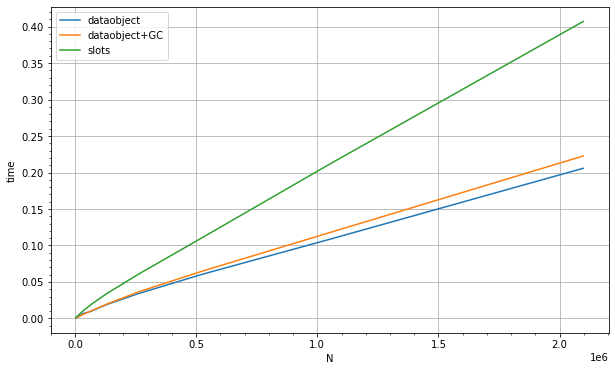

In [33]:
Ns = [2**n for n in range(12,22)]
Ms = list(range(12,22))
timings1 = np.array([test_without_gc(N) for N in Ns], 'd')
timings2 = np.array([test_with_gc(N) for N in Ns], 'd')
timings3 = np.array([test_with_slots(N) for N in Ns], 'd')
plt.figure(figsize=(10,6))
plt.plot(Ns, timings1, label="dataobject")
plt.plot(Ns, timings2, label="dataobject+GC")
plt.plot(Ns, timings3, label="slots")
plt.legend()
plt.xlabel('N')
plt.ylabel('time')
plt.minorticks_on()
plt.grid(1)
plt.savefig("objects_without_cyclic_GC3.jpg")
plt.show()

In [10]:
import tracemalloc
class Tracer:
    def __enter__(self):
        if tracemalloc.is_tracing():
            raise ValueError('nesting tracemalloc is not allowed')
        self.allocated = None
        tracemalloc.start()
        return self
    def __exit__(self, exc_type, exc_value, exc_traceback):
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        self.allocated = current

In [11]:
def test_with_gc(N=1000000):
    for i in range(N):
        p = PointGC(i, i+1)
        
def test_without_gc(N=1000000):
    for i in range(N):
        p = Point(i, i+1)

def test_with_slots(N=1000000):
    for i in range(N):
        p = PointSlots(i, i+1)


In [12]:
def mtrace(Ns, func):
    gc.enable()
    gc.collect()
    gc.collect()
    gc.collect()
    Ds = []
    for N in Ns:
        with Tracer() as t:
            func(N)
        Ds.append(t.allocated)
    return Ds

[896, 731, 0, 0, 0, 0, 0, 0, 0, 0]
[504, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[504, 0, 0, 0, 0, 0, 0, 0, 0, 0]


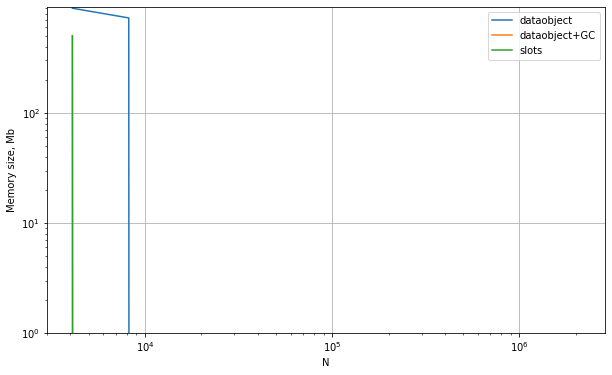

In [13]:
Ns = [2**n for n in range(12,22)]
Ds1 = mtrace(Ns, test_without_gc)
Ds2 = mtrace(Ns, test_with_gc)
Ds3 = mtrace(Ns, test_with_slots)
print(Ds1)
print(Ds2)
print(Ds3)

plt.figure(figsize=(10,6))
plt.loglog(Ns, Ds1, label="dataobject")
plt.loglog(Ns, Ds2, label="dataobject+GC")
plt.loglog(Ns, Ds3, label="slots")
plt.legend()
plt.xlabel('N')
plt.ylabel('Memory size, Mb')
plt.minorticks_on()
plt.grid(1)
y1, y2 = plt.ylim()
plt.ylim(1, y2)
plt.savefig("objects_without_cyclic_GC4.jpg")
plt.show()